In [19]:
%matplotlib inline
import torch
import pyro
import pyro.distributions as dist
import pyro.ops.stats as stats
from IPython.core.pylabtools import figsize
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

## 1.2 Distributions

An important class of models (stochastic functions) used explicitly to compute the probability of the outputs given the inputs. Pyro use [**torch.distributions**](https://pytorch.org/docs/master/distributions.html) which contains parameterizable probability distributions and sampling functions. This allows the construction of stochastic computation graphs and stochastic gradient estimators for optimization. Each probability distributions are equipped with several  methods such as:

* **prob()**: $\log p(\mathbf{x} \mid \theta ^{*})$
* **mean**: $\mathbb{E}_{p(\mathbf{x} \mid \theta ^{*})}[\mathbf{x}]$
* **sample**: $\mathbf{x}^{*} \sim  {p(\mathbf{x} \mid \theta ^{*})}$




**Code 1**: Let define the binomial distribution $w \sim Binomial(N, p)$  as the distribution for our observation and $p\sim Uniform(0,1)$ as the prior distribution

In [3]:
N = 9  
p = 0.5 
likelihood = dist.Binomial(total_count=9, probs=0.5)
prior =  dist.Uniform(0,1)

In [4]:
W = torch.tensor(6.)
likelihood.log_prob(W).exp().item()

0.1640624701976776

## Grid approximation

In [5]:
from estimatation import grid_approximation

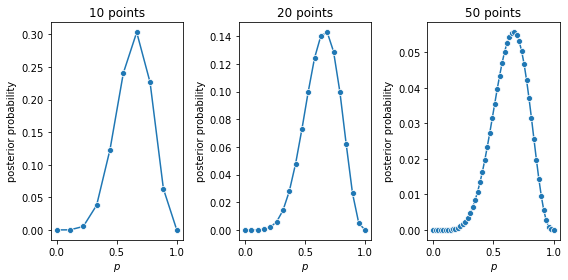

In [6]:
steps = [10, 20, 50]
fig, axs = plt.subplots(ncols=len(steps), sharex=True, figsize=(8,4))
for i, step in enumerate(steps):
    p_grid, posterior = grid_approximation(step)
    sns.lineplot(p_grid, posterior, marker="o", ax=axs[i])
    axs[i].set(xlabel="$p$", ylabel="posterior probability",
       title=f"{step} points");
fig.tight_layout()

### MAP vs Analtical

In [7]:
from estimatation import MAP, precis

In [8]:
def model(w, n=9):
    p = pyro.sample("p", dist.Uniform(0, 1))  # uniform prior
    pyro.sample("w", dist.Binomial(n, p), obs=w)  # binomial likelihood

In [9]:
globe_qa = MAP(model).run(torch.tensor(6.))

In [10]:
# display summary of quadratic approximation
precis(globe_qa)

,Mean,StdDev,|0.89,0.89|
p,0.63,0.14,0.42,0.85


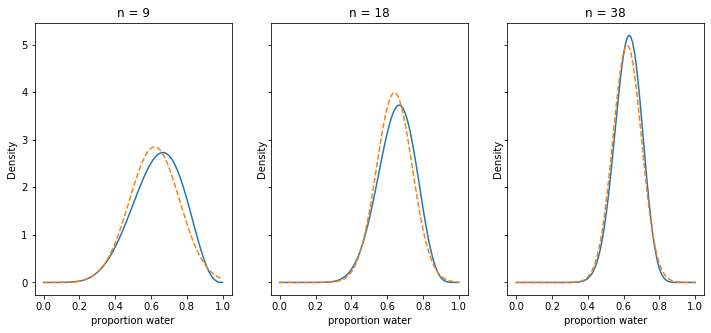

In [11]:
npoints = [9, 18, 38]
nwaters = [6.0, 12.0, 24.0]
x = torch.linspace(0, 1, 101)
w =6
fig, axs = plt.subplots(ncols=len(npoints), sharey=True, figsize=(12,5))
for i, n in enumerate(npoints):
    globe_qa = MAP(model).run(torch.tensor(nwaters[i]), n)
    precis_df = precis(globe_qa)
    sns.lineplot(x, dist.Beta(nwaters[i] + 1, n - nwaters[i] + 1).log_prob(x).exp(), ax=axs[i])
    sns.lineplot(x, dist.Normal(precis_df["Mean"][0],
                            precis_df["StdDev"][0]).log_prob(x).exp(), ax=axs[i])
    axs[i].set(xlabel="proportion water", ylabel="Density", title=f"n = {n}")
    axs[i].lines[1].set_linestyle("--")
   
    

### sampling from grid approximator

In [12]:
p_grid = torch.linspace(start=0, end=1, steps=1000)
prior = torch.tensor(1.).repeat(1000)
likelihood = dist.Binomial(total_count=9,
                           probs=p_grid).log_prob(torch.tensor(6.)).exp()
posterior = likelihood * prior
posterior = posterior / sum(posterior)

sample from grid approximation

In [13]:
samples = dist.Empirical(p_grid, posterior.log()).sample(torch.Size([int(1e4)]))

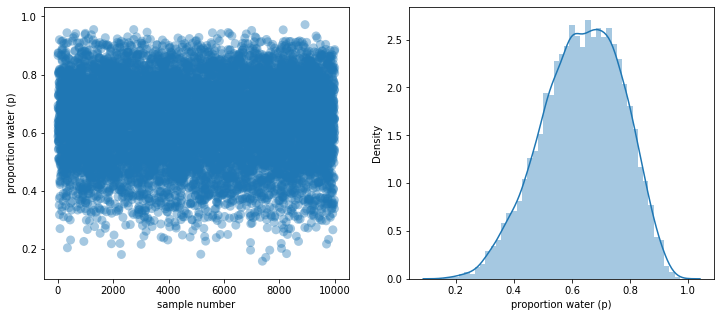

In [14]:
fig, axs = plt.subplots(ncols=2, figsize=(12,5))
sns.scatterplot(range(len(samples)), samples, s=80, alpha=0.4, edgecolor="none", ax=axs[0])
axs[0].set(xlabel="sample number", ylabel="proportion water (p)")
sns.distplot(samples, ax=axs[1])
axs[1].set(xlabel="proportion water (p)", ylabel="Density");

From above figure:
- Many more sample near 0.6 and very few samples below 0.25
- The estimated density is very similar to ideal posterior we computed via grid approximation

### Summarizing samples

#### Interval of defined boundaries

**Posterior probabibility that the proportional of water is less than 0.5**



In [15]:
#grid approximation
(posterior[p_grid < 0.5]).sum().item()

0.17187461256980896

 so about 17% of the posterior probibility is below 0.5

* using samples

In [16]:
#use samples
(samples < 0.5).sum().float() / 1e4

tensor(0.1704)

Nearly the same answer as grid approximation

**How much posterior probability lies between 0.5 and 0.7**

In [17]:
((samples > 0.5) & (samples < 0.75)).sum().float() / len(samples)

tensor(0.6086)

About 61% of the posterior probability lies between 0.5 and 0.75

#### Intervals of defined mass

In [20]:
#The boundaries of the lower 80% posterior probability.
stats.quantile(samples, 0.8)

tensor(0.7598)

In [21]:
#the middle 80% interval lies between the 10th percentile and the 90th percentile.
stats.quantile(samples, [0.1, 0.9])

tensor([0.4504, 0.8099])

##### Suppose we obseve three water after 3 count

In [22]:
p_grid = torch.linspace(start=0, end=1, steps=1000)
prior = torch.tensor(1.).repeat(1000)
likelihood = dist.Binomial(total_count=3,
                           probs=p_grid).log_prob(torch.tensor(3.)).exp()
posterior = likelihood * prior
posterior = posterior / posterior.sum()
samples = dist.Empirical(p_grid, posterior.log()).sample(torch.Size([int(1e4)]))

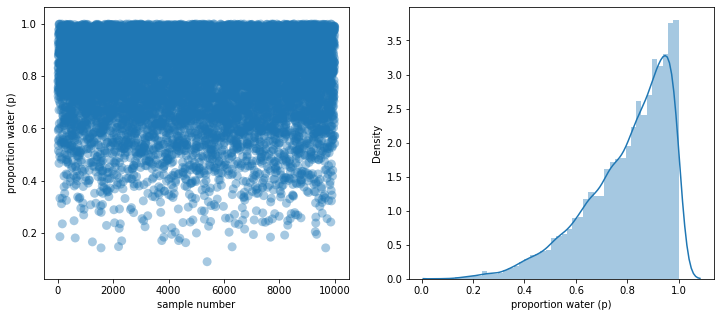

In [23]:
fig, axs = plt.subplots(ncols=2, figsize=(12,5))
sns.scatterplot(range(len(samples)), samples, s=80, alpha=0.4, edgecolor="none", ax=axs[0])
axs[0].set(xlabel="sample number", ylabel="proportion water (p)")
sns.distplot(samples, ax=axs[1])
axs[1].set(xlabel="proportion water (p)", ylabel="Density");

 Many more sample near 1 and very few samples below 0.2

The 50% percentile confidence interval

In [24]:
from statistics_functions import get_percentile_confidence_interval

In [25]:
get_percentile_confidence_interval(samples, 0.5)

,LPI,UPI
0,25.00,75.00
1,0.71,0.93


This interval assigns 25% of the probability mass above and below the interval. So it pro-
vides the central 50% probability. But in this example, it ends up excluding the most prob-
able parameter values, near p = 1

In [26]:
from statistics_functions import get_hpdi_confidence_interval

In [27]:
get_hpdi_confidence_interval(samples, 0.5)

,LPI,UPI
0,50.00,50.0
1,0.84,1.0


#### Point estimate

In [28]:
## MAP estimate
p_grid[posterior.argmax()].item()

1.0

In [29]:
from statistics_functions import get_chain_mode

In [30]:
get_chain_mode(samples)

tensor(0.9790)

In [31]:
## mean 
print(samples.mean())
print(samples.median())

tensor(0.7994)
tensor(0.8408)
